# Todo
* Merge multiple Sarsa, Qlearning functions into one 

# Ex6.9: Windy Grid-World with Kings moves using SARSA on-Policy Control

![Bild](ex65.png)

Re-solve the windy grid-world assuming eight possible actions, including the diagonal moves, rather than four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?

# Ex6.10: Stochastic Wind

Re-solve the windy grid-world task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

## Defining the environment

In [2]:
class Grid:
    '''Class defining the environment'''
    
    def __init__(self, shapex, shapey, wind, start, goal):
        self.shapex = shapex
        self.shapey = shapey
        self.wind   = wind
        self.start  = start
        self.goal   = goal
    
    def get_wind(self, pos):
        '''pos : tuple(int, int) : position on grid'''
        return self.wind[pos[1]]
    
    def set_start(self, pos):
        '''pos : tuple(int, int) : position of new start'''
        self.start = pos
        
    def set_goal(self, pos):
        '''pos : tuple(int, int) : position of new goal'''
        self.goal = pos
    
    def is_in_grid(self, pos):
        '''pos : tuple(int, int) : position on grid'''
        return ((0 <= pos[0] < self.shapex) and (0 <= pos[1] < self.shapey))
    
    def show_path(self, path):
        '''path : list(tuple(int, int)) : List of legal moves'''
        
        length    = len(path)
        grid      = np.full((self.shapex, self.shapey), -0.1)
        fade      = np.linspace(0.1, 1, num=length)
        
        pos       = self.start
        grid[pos] = 0
        
        for i in range(length):
            pos       = move(self, pos, path[i])
            grid[pos] = fade[i]
            
        grid[self.goal] = 1
        plt.imshow(grid)

In [3]:
height = 7
width  = 10
start  = (3, 0)
goal   = (3, 7)
wind   = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
grid   = Grid(height, width, wind, start, goal)

## Setting up

In [4]:
king_moves      = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
king_moves_noop = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1), (0, 0)]
compass_moves   = [(-1, 0), (0, -1), (0, 1), (1, 0)]

stochastic_wind = False
moves           = []
move_idx        = 0

In [5]:
def setup(move_type, stochastic=False):
    '''
    move_type  : list(tuple(int, int)) : List of available moves
    stochastic : bool                  : Decides if wind should be stochastic
    
    Sets up environment before calling sarsa(...)
    '''
    
    global moves, stochastic_wind, move_idx
    
    moves           = move_type
    move_idx        = {moves[i] : i for i in range(len(moves))}
    stochastic_wind = stochastic

In [6]:
def move(grid, pos, act):
    '''
    grid : Grid            : Current environment
    pos  : tuple(int, int) : Current position
    act  : tuple(int, int) : Legal move
    
    Moves to position if we're in pos and take act 
    
         : tuple(int, int) : New position
    '''
    
    global stochastic_wind    
    
    x_pos      = pos[0]
    y_pos      = pos[1]
    wind_move  = grid.get_wind(pos)
    
    if stochastic_wind and wind_move > 0:
        r = np.random.randint(3)
        
        if r == 1:
            wind_move += 1
        elif r == 2:
            wind_move -= 1
    
    x_move = act[0] - wind_move
    y_move = act[1]
    
    x_pos += x_move
    y_pos += y_move
    
    # Clamp values to grid-shape
    x_pos  = max(0, min(grid.shapex - 1, x_pos))
    y_pos  = max(0, min(grid.shapey - 1, y_pos))
    
    newpos = (int(x_pos), int(y_pos))

    return newpos

In [7]:
def epsilon_greedy_policy(Q, pos, epsilon=0.1):
    '''    
    Q       : np.array(int, int, int) : State-Action values
    pos     : tuple(int, int)         : Current position
    epsilon : float in (0, 1)         : Parameter for epsilon-greedy policy
    
    Exploratory policy we use to learn Q
    
    act     : tuple(int, int)         : Legal move
    '''
    
    global moves
    
    act_i = None
    r     = np.random.rand()
    
    if r > epsilon:
        act_i = np.argmax(Q[pos])
    else:
        act_i = np.random.choice(len(moves))
        
    return moves[act_i]

In [8]:
def trace(grid, Q):
    '''
    grid    : Grid                    : Current environment
    Q       : np.array(int, int, int) : State-Action values
    
    Records Greedy Path from grid-start
    
    path    : list(tuple(int, int))   : Actions taken until termination
    '''
    
    global moves
    
    S = grid.start
    A = moves[np.argmax(Q[S])]
    path = []
    
    while S != grid.goal:
        path.append(A)
        Sn = move(grid, S, A)
        An = moves[np.argmax(Q[Sn])]
        S  = Sn
        A  = An
    
    return path

## SARSA (On-Policy Temporal Difference Control)

In [9]:
def sarsa(grid, episodes, alpha=0.1, epsilon=0.3, gamma=1):
    '''
    grid        : Grid                    : Current environment
    episodes    : int                     : Amount of episodes we should train for
    alpha       : float in (0, 1]         : Learning rate
    epsilon     : float in (0, 1)         : Parameter for epsilon-greedy policy
    gamma       : float in [0, 1]         : Discount Parameter
    
    SARSA On-Policy TD Control Algorithm
    
    Q           : np.array(int, int, int) : State-Action values
    steps_taken : np.array(int)           : Amount of steps needed to reach goal
    '''
    
    global moves, move_idx
    
    # --- Setup
    possible_moves = len(moves) # King moves: 8
    Q              = np.random.rand(grid.shapex, grid.shapey, possible_moves)
    Q[grid.goal]   = 0 # Goal has to be zero
    steps_taken    = np.zeros(episodes)
    
    # --- Episode Loop
    for episode in range(episodes):
        
        S = grid.start
        A = epsilon_greedy_policy(Q, S, epsilon=epsilon)
        
        while S != grid.goal:
            Sn      = move(grid, S, A)
            An      = epsilon_greedy_policy(Q, Sn, epsilon=epsilon)
            R       = 0 if (Sn == grid.goal) else -1
            
            idx     = (S[0],  S[1],  move_idx[A])
            idxn    = (Sn[0], Sn[1], move_idx[An])
            Q[idx] += alpha * (R + gamma * Q[idxn] - Q[idx])
            
            S       = Sn
            A       = An
            steps_taken[episode] += 1
        
    return Q, steps_taken

## Expected SARSA

In [10]:
def expected_sarsa(grid, episodes, alpha=0.1, epsilon=0.3, gamma=1):
    '''
    grid        : Grid                    : Current environment
    episodes    : int                     : Amount of episodes we should train for
    alpha       : float in (0, 1]         : Learning rate
    epsilon     : float in (0, 1)         : Parameter for epsilon-greedy policy
    gamma       : float in [0, 1]         : Discount Parameter
    
    SARSA On-Policy TD Control Algorithm - like Q-Learning,
    but instead of choosing max of next state-action choose its expected value
    
    Q           : np.array(int, int, int) : State-Action values
    steps_taken : np.array(int)           : Amount of steps needed to reach goal
    '''
    
    global moves, move_idx
    
    # --- Setup
    possible_moves = len(moves) # King moves: 8
    Q              = np.random.rand(grid.shapex, grid.shapey, possible_moves)
    Q[grid.goal]   = 0 # Goal has to be zero
    steps_taken    = np.zeros(episodes)
    
    # --- Episode Loop
    for episode in range(episodes):
        
        S = grid.start
        
        while S != grid.goal:
            A       = epsilon_greedy_policy(Q, S, epsilon=epsilon)
            Sn      = move(grid, S, A)
            R       = 0 if (Sn == grid.goal) else -1
            
            idx     = (S[0],  S[1],  move_idx[A])
            
            
            # Unsure if 'mean' or 'sum' should be chosen. By the book it should be sum, 
            # which leads to evergrowing values and eventually an overflow. 
            # I suppose the book meant to use mean but forgot the regularization term in front of the sum
            probs   = [1 - epsilon if a == np.argmax(Q[Sn]) else epsilon for a in range(possible_moves)]
            sum_    = np.mean([probs[a] * Q[Sn[0], Sn[1], a] for a in range(possible_moves)])
            
            Q[idx] += alpha * (R + gamma * sum_ - Q[idx])
            
            S       = Sn
            steps_taken[episode] += 1
        
    return Q, steps_taken

## Q-Learning (Off-Policy Temporal Difference Control)

In [11]:
def q_learning(grid, episodes, alpha=0.1, epsilon=0.3, gamma=1):
    '''
    grid        : Grid                    : Current environment
    episodes    : int                     : Amount of episodes we should train for
    alpha       : float in (0, 1]         : Learning rate
    epsilon     : float in (0, 1)         : Parameter for epsilon-greedy policy
    gamma       : float in [0, 1]         : Discount Parameter
    
    Q-Learning Off-Policy TD Control Algorithm
    
    Q           : np.array(int, int, int) : State-Action values
    steps_taken : np.array(int)           : Amount of steps needed to reach goal
    '''
    
    global moves, move_idx
    
    # --- Setup
    possible_moves = len(moves) # King moves: 8
    Q              = np.random.rand(grid.shapex, grid.shapey, possible_moves)
    Q[grid.goal]   = 0 # Goal has to be zero
    steps_taken    = np.zeros(episodes)
    
    # --- Episode Loop
    for episode in range(episodes):
        
        S = grid.start
        
        while S != grid.goal:
            A       = epsilon_greedy_policy(Q, S, epsilon=epsilon)
            Sn      = move(grid, S, A)
            R       = 0 if (Sn == grid.goal) else -1
            
            idx     = (S[0],  S[1],  move_idx[A])
            idxn    = (Sn[0], Sn[1], np.argmax(Q[Sn]))
            Q[idx] += alpha * (R + gamma * Q[idxn] - Q[idx])
            
            S       = Sn
            steps_taken[episode] += 1
        
    return Q, steps_taken

## Double Q-Learning

In [12]:
def double_q_learning(grid, episodes, alpha=0.1, epsilon=0.3, gamma=1):
    '''
    grid        : Grid                    : Current environment
    episodes    : int                     : Amount of episodes we should train for
    alpha       : float in (0, 1]         : Learning rate
    epsilon     : float in (0, 1)         : Parameter for epsilon-greedy policy
    gamma       : float in [0, 1]         : Discount Parameter
    
    Q-Learning Off-Policy TD Control Algorithm
    
    Q           : np.array(int, int, int) : State-Action values
    steps_taken : np.array(int)           : Amount of steps needed to reach goal
    '''
    
    global moves, move_idx
    
    # --- Setup
    possible_moves = len(moves) # King moves: 8
    Q1              = np.random.rand(grid.shapex, grid.shapey, possible_moves)
    Q2              = np.random.rand(grid.shapex, grid.shapey, possible_moves)
    Q1[grid.goal]   = 0 # Goal has to be zero
    Q2[grid.goal]   = 0 # Goal has to be zero
    steps_taken    = np.zeros(episodes)
    
    # --- Episode Loop
    for episode in range(episodes):
        
        S = grid.start
        
        while S != grid.goal:
            A       = epsilon_greedy_policy(Q1 + Q2, S, epsilon=epsilon)
            Sn      = move(grid, S, A)
            R       = 0 if (Sn == grid.goal) else -1
            
            r       = np.random.rand()
            idx     = (S[0],  S[1],  move_idx[A])
            
            if r > 0.5:
                idxn     = (Sn[0], Sn[1], np.argmax(Q1[Sn]))
                Q1[idx] += alpha * (R + gamma * Q2[idxn] - Q1[idx])
            else:
                idxn     = (Sn[0], Sn[1], np.argmax(Q2[Sn]))
                Q2[idx] += alpha * (R + gamma * Q1[idxn] - Q2[idx])
                
            S       = Sn
            steps_taken[episode] += 1
        
    return Q1, steps_taken

# SARSA Results

## King Moves after 8000 episodes
Learns a optimal path with length of 7 or 8

Total Reward: -7
[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, 1)]


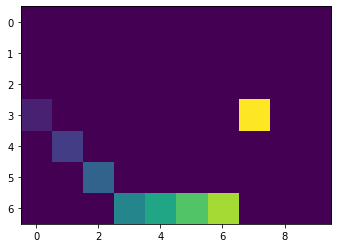

In [13]:
setup(king_moves, stochastic=False)
Q_k, s = sarsa(grid, 8000)
path   = trace(grid, Q_k)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

This plot shows a real fast convergence to good values

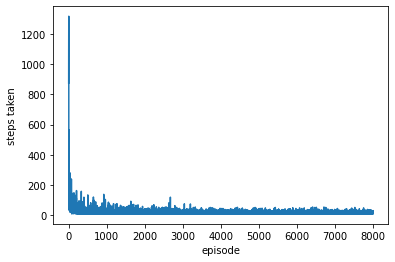

In [14]:
plt.plot(np.arange(len(s)), s)
plt.xlabel("episode")
plt.ylabel("steps taken")
plt.show()

The value approximate value function of the board 

## Compass Moves after 8000 episodes
Learns a (optimal) path with length of 15

Total Reward: -15
[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, -1)]


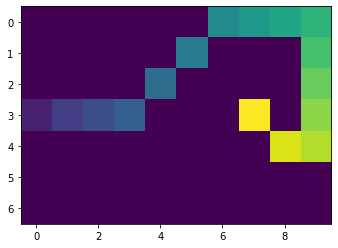

In [15]:
setup(compass_moves, stochastic=False)
Q_c, _ = sarsa(grid, 8000)
path   = trace(grid, Q_c)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

## King Moves after 8000 episodes + Stochastic Wind
Gives different results each time due to stochasticity. They can get quite messy

Total Reward: -9
[(1, 1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, -1)]


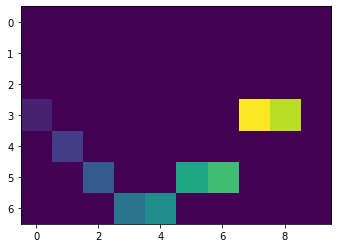

In [16]:
setup(king_moves, stochastic=True)
Q_ks, _ = sarsa(grid, 8000)
path    = trace(grid, Q_ks)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

## King Moves + No-op after 8000 episodes
It doesn't get better if we include the no-op

Total Reward: -7
[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, 1)]


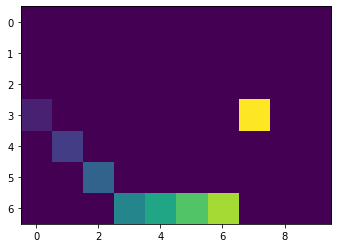

In [17]:
setup(king_moves_noop, stochastic=False)
Q_kn, _ = sarsa(grid, 8000)
path    = trace(grid, Q_kn)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

## Expected Sarsa with King Moves after 8000 Episodes

Total Reward: -7
[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, 1)]


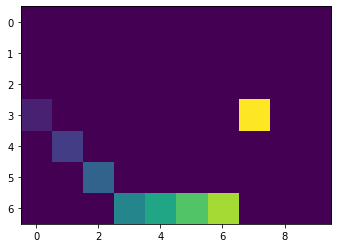

In [18]:
setup(king_moves, stochastic=False)
Q_ke, u = expected_sarsa(grid, 8000)
path    = trace(grid, Q_ke)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

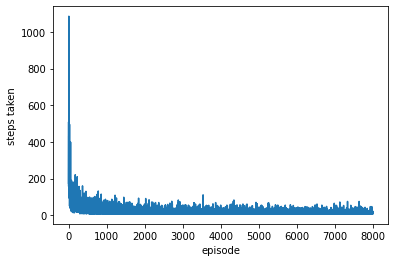

In [19]:
plt.plot(np.arange(len(u)), u)
plt.xlabel("episode")
plt.ylabel("steps taken")
plt.show()

# Q-Learning Results
## King moves after 8000 episodes

Total Reward: -7
[(-1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]


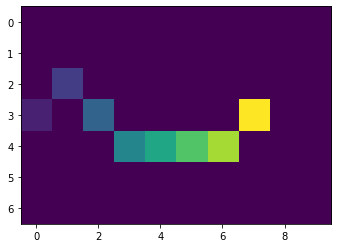

In [20]:
setup(king_moves, stochastic=False)
Q_kq, z = q_learning(grid, 8000)
path    = trace(grid, Q_kq)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

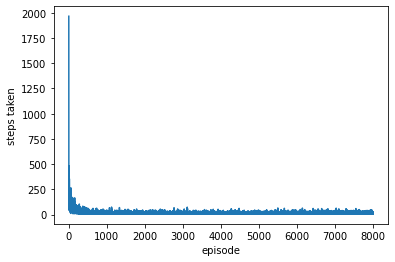

In [21]:
plt.plot(np.arange(len(z)), z)
plt.xlabel("episode")
plt.ylabel("steps taken")
plt.show()

## Double Q-Learning with King moves after 8000 episodes

Total Reward: -7
[(1, 1), (0, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1)]


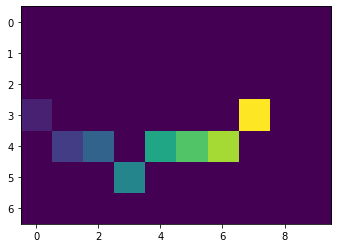

In [22]:
setup(king_moves, stochastic=False)
Q_kd, y = double_q_learning(grid, 8000)
path    = trace(grid, Q_kd)
grid.show_path(path)
print(f"Total Reward: {-len(path)}")
print(path)

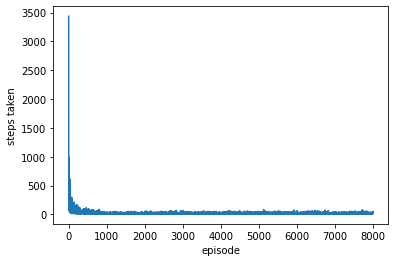

In [23]:
plt.plot(np.arange(len(y)), y)
plt.xlabel("episode")
plt.ylabel("steps taken")
plt.show()